Instructions for students:

Change the colab runtime type to 'T4 GPU' for this notebook.

Run each cell in this notebook, one by one, reading the comment above the cell first. This will aid in understanding what the code is doing.

After running all cells, you can compare the MAE of your deep learning model with that of other models or baseline methods. Additionally, you can fine-tune hyperparameters, adjust model architecture, or preprocess the data differently to try and improve the MAE.

# Deep learning for timeseries

## A temperature-forecasting example

In this example, we aim to predict the temperature 24 hours in the future.

In [ ]:
!wget https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
!unzip jena_climate_2009_2016.csv.zip

--2024-05-21 19:14:25--  https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.67.22, 52.216.32.112, 16.182.68.72, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.67.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13565642 (13M) [application/zip]
Saving to: ‘jena_climate_2009_2016.csv.zip’

jena_climate_2009_2 100%[===================>]  12.94M  5.94MB/s    in 2.2s    

2024-05-21 19:14:29 (5.94 MB/s) - ‘jena_climate_2009_2016.csv.zip’ saved [13565642/13565642]

Archive:  jena_climate_2009_2016.csv.zip
  inflating: jena_climate_2009_2016.csv  
  inflating: __MACOSX/._jena_climate_2009_2016.csv  


**Inspecting the data of the Jena weather dataset**

Jena Climate is weather timeseries dataset recorded at the Weather Station of the Max Planck Institute for Biogeochemistry in Jena, Germany.

Jena Climate dataset is made up of 14 different quantities (such air temperature, atmospheric pressure, humidity, wind direction, and so on) were recorded every 10 minutes, over several years. This dataset covers data from January 1st 2009 to December 31st 2016.

For more information, please go to:
https://www.kaggle.com/datasets/mnassrib/jena-climate

In [ ]:
import os
fname = os.path.join("jena_climate_2009_2016.csv")

with open(fname) as f:
    data = f.read()

lines = data.split("\n")
header = lines[0].split(",")
lines = lines[1:]
print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420451


**Parsing the data**

In [ ]:
import numpy as np
temperature = np.zeros((len(lines),))
raw_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(",")[1:]]
    temperature[i] = values[1]
    raw_data[i, :] = values[:]

**Plotting the temperature timeseries**

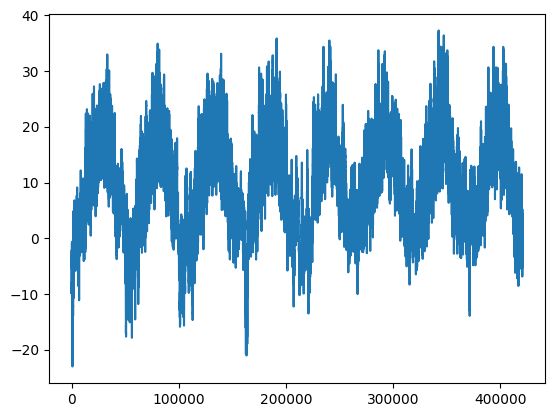

In [ ]:
from matplotlib import pyplot as plt
plt.plot(range(len(temperature)), temperature)

**Plotting the first 10 days of the temperature timeseries**

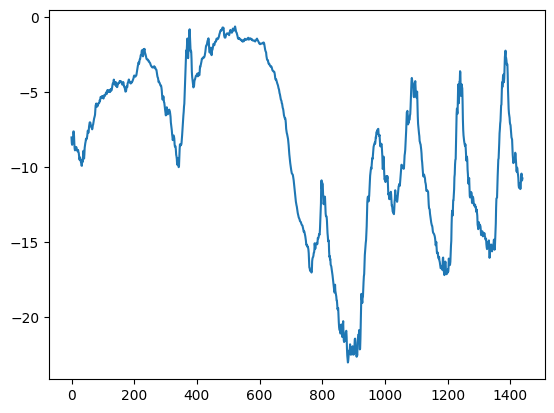

In [ ]:
plt.plot(range(1440), temperature[:1440])

**Computing the number of samples we'll use for each data split**

In [ ]:
num_train_samples = int(0.5 * len(raw_data))
num_val_samples = int(0.25 * len(raw_data))
num_test_samples = len(raw_data) - num_train_samples - num_val_samples
print("num_train_samples:", num_train_samples)
print("num_val_samples:", num_val_samples)
print("num_test_samples:", num_test_samples)

num_train_samples: 210225
num_val_samples: 105112
num_test_samples: 105114


### Preparing the data

**Normalizing the data**

Normalizing data is crucial for deep learning for several reasons:

Improved convergence: Normalizing data helps in speeding up the convergence of gradient-based optimization algorithms, such as stochastic gradient descent (SGD). When features are on different scales, the optimization process can be slowed down, as the gradients corresponding to different features may vary significantly. Normalization scales all features to a similar range, which helps the optimization algorithm converge faster.

Better generalization: Normalizing data can prevent the model from being biased towards features with larger magnitudes. Without normalization, features with larger scales may dominate the learning process, leading to a model that performs poorly on unseen data. Normalization ensures that all features contribute equally to the learning process, resulting in a model that generalizes better to new data.

Stability: Normalizing data helps in stabilizing the training process. Deep neural networks are sensitive to the scale of input features, and normalizing data prevents extreme values from causing numerical stability issues during training. This stability ensures that the model learns meaningful patterns from the data without being affected by outliers or extreme values.

In [ ]:
mean = raw_data[:num_train_samples].mean(axis=0)
raw_data -= mean
std = raw_data[:num_train_samples].std(axis=0)
raw_data /= std

In [ ]:
mean

array([ 988.74929466,    8.82590329,  282.9050718 ,    4.31331863,
         75.87275476,   13.14569946,    9.19414209,    3.95148184,
          5.81050741,    9.30208943, 1218.45204015,    2.14977462,
          3.56048029,  176.4405232 ])

In [ ]:
std

array([ 8.50510865,  8.77098361,  8.86560463,  7.08011256, 16.62877917,
        7.6012955 ,  4.14689697,  4.76961017,  2.63277288,  4.1996886 ,
       42.0392747 ,  1.53358803,  2.32305586, 85.85032063])

Create sequences of input data, where each sequence contains a window of historical temperature data along with corresponding target temperatures.

In [ ]:
import numpy as np
from tensorflow import keras
int_sequence = np.arange(10)
dummy_dataset = keras.utils.timeseries_dataset_from_array(
    data=int_sequence[:-3],
    targets=int_sequence[3:],
    sequence_length=3,
    batch_size=2,
)

for inputs, targets in dummy_dataset:
    for i in range(inputs.shape[0]):
        print([int(x) for x in inputs[i]], int(targets[i]))

[0, 1, 2] 3
[1, 2, 3] 4
[2, 3, 4] 5
[3, 4, 5] 6
[4, 5, 6] 7


In [ ]:
import numpy as np
from tensorflow import keras
int_sequence = np.arange(10)
dummy_dataset = keras.utils.timeseries_dataset_from_array(
    data=int_sequence[:-5],
    targets=int_sequence[5:],
    sequence_length=3,
    batch_size=2,
)

for inputs, targets in dummy_dataset:
    for i in range(inputs.shape[0]):
        print([int(x) for x in inputs[i]], int(targets[i]))

[0, 1, 2] 5
[1, 2, 3] 6
[2, 3, 4] 7


**Instantiating datasets for training, validation, and testing**

In [ ]:
sampling_rate = 6
sequence_length = 120
delay = sampling_rate * (sequence_length + 24 - 1)
batch_size = 256

train_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=0,
    end_index=num_train_samples)

val_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples,
    end_index=num_train_samples + num_val_samples)

test_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples + num_val_samples)

**Inspecting the output of one of our datasets**

In [ ]:
for samples, targets in train_dataset:
    print("samples shape:", samples.shape)
    print("targets shape:", targets.shape)
    break

samples shape: (256, 120, 14)
targets shape: (256,)


In [ ]:
for samples, targets in train_dataset:
    print("samples shape:", samples.shape)
    print("targets shape:", targets.shape)

    print(samples[0][0])
    print(targets[0])
    print(samples[0][1])
    print(targets[0])

    break

samples shape: (256, 120, 14)
targets shape: (256,)
tf.Tensor(
[ 1.04063401 -0.46926359 -0.54650213 -0.32814713  0.3985407  -0.60459424
 -0.51704735 -0.5139795  -0.53195147 -0.53148927  0.68764174 -0.84101767
 -0.89557911  0.09970233], shape=(14,), dtype=float64)
tf.Tensor(4.24, shape=(), dtype=float64)
tf.Tensor(
[ 0.99360346 -0.35411117 -0.42919485 -0.24340272  0.26022627 -0.52171363
 -0.44229266 -0.44688806 -0.45978421 -0.45767427  0.56418575 -1.18009178
 -1.1366409  -0.8461299 ], shape=(14,), dtype=float64)
tf.Tensor(4.24, shape=(), dtype=float64)


### Let's try a basic machine-learning model

In this model, we will use only the basic Dense layers. This will be our baseline model and we will show how RNNS can improve performance beating the baseline MAE score.

**Training and evaluating a densely connected model**

Mean Absolute Error is one of the common metrics used for regression tasks like temperature forecasting. Here's how you would compute MAE:

a. Use the trained model to make predictions on the testing dataset.

b. For each prediction, calculate the absolute difference between the predicted temperature and the actual temperature.

c. Take the average of all these absolute differences to get the Mean Absolute Error.

MAE represents the average magnitude of errors between predicted and actual temperatures. For example, if the MAE is 2 degrees Celsius, it means that, on average, the model's predictions deviate from the actual temperatures by 2 degrees Celsius. Lower MAE values indicate better performance, as they imply that the model's predictions are closer to the actual values.



In [ ]:
print(sequence_length)
print(raw_data.shape)

120
(420451, 14)


In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Flatten()(inputs)
x = layers.Dense(16, activation="relu")(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_dense.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_dense.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 50s 59ms/step - loss: 12.8361 - mae: 2.7731 - val_loss: 10.5039 - val_mae: 2.5659
Epoch 2/10
819/819 [==============================] - 50s 60ms/step - loss: 9.3200 - mae: 2.3983 - val_loss: 13.4846 - val_mae: 2.9403
Epoch 3/10
819/819 [==============================] - 39s 48ms/step - loss: 8.4196 - mae: 2.2816 - val_loss: 13.1146 - val_mae: 2.8458
Epoch 4/10
819/819 [==============================] - 38s 46ms/step - loss: 7.8559 - mae: 2.2041 - val_loss: 10.0627 - val_mae: 2.5101
Epoch 5/10
819/819 [==============================] - 39s 48ms/step - loss: 7.4601 - mae: 2.1505 - val_loss: 10.2020 - val_mae: 2.5305
Epoch 6/10
819/819 [==============================] - 48s 58ms/step - loss: 7.1748 - mae: 2.1080 - val_loss: 10.1978 - val_mae: 2.5296
Epoch 7/10
819/819 [==============================] - 47s 58ms/step - loss: 6.9326 - mae: 2.0730 - val_loss: 11.6216 - val_mae: 2.7063
Epoch 8/10
819/819 [==============================] - 

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Flatten()(inputs)
x = layers.Dense(20, activation="relu")(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_dense.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=20,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_dense.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

OSError: No file or directory found at jena_dense.keras

**Plotting results**

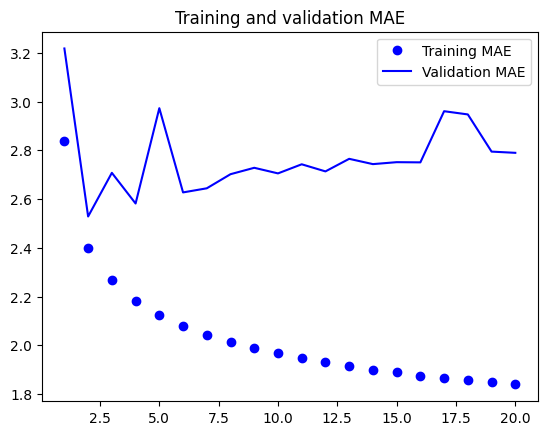

In [ ]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

### Let's try a 1D convolutional model

Using a 1D convolutional neural network (CNN) for temperature forecasting involves applying convolutional layers to input sequences of temperature data.

Model Architecture:

1. Start with an input layer that takes sequences of temperature data as input.
2. Add one or more 1D convolutional layers to extract features from the input sequences. Each convolutional layer applies a set of filters across the input sequence, capturing patterns at different temporal scales.
3. Optionally, you can add pooling layers (e.g., MaxPooling1D) to downsample the output of the convolutional layers.
4. Flatten or use global pooling to convert the output of the convolutional layers into a 1D vector.
5. Add one or more fully connected layers (Dense layers) to perform the final regression prediction.
6. Optionally, include dropout layers for regularization to prevent overfitting.
7. The output layer should have a single neuron since temperature forecasting is a regression task, and it should use an appropriate activation function (e.g., linear activation for regression).

In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Conv1D(8, 24, activation="relu")(inputs)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 12, activation="relu")(x)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 6, activation="relu")(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_conv.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history_Conv = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_conv.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 42s 48ms/step - loss: 21.6798 - mae: 3.6332 - val_loss: 15.5339 - val_mae: 3.1277
Epoch 2/10
819/819 [==============================] - 48s 58ms/step - loss: 15.2672 - mae: 3.0972 - val_loss: 14.7193 - val_mae: 3.0413
Epoch 3/10
819/819 [==============================] - 39s 48ms/step - loss: 13.8631 - mae: 2.9488 - val_loss: 16.9868 - val_mae: 3.2931
Epoch 4/10
819/819 [==============================] - 38s 46ms/step - loss: 13.0255 - mae: 2.8550 - val_loss: 14.2297 - val_mae: 2.9489
Epoch 5/10
819/819 [==============================] - 49s 59ms/step - loss: 12.3470 - mae: 2.7795 - val_loss: 14.1126 - val_mae: 2.9322
Epoch 6/10
819/819 [==============================] - 48s 59ms/step - loss: 11.7960 - mae: 2.7163 - val_loss: 15.7823 - val_mae: 3.1509
Epoch 7/10
819/819 [==============================] - 39s 47ms/step - loss: 11.3742 - mae: 2.6699 - val_loss: 15.4119 - val_mae: 3.0512
Epoch 8/10
819/819 [============================

In [ ]:
loss = history_Conv.history["mae"]
val_loss = history_Conv.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

NameError: name 'history_Conv' is not defined

In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Conv1D(8, 24, activation="relu")(inputs)
x = layers.MaxPooling1D(3)(x)
x = layers.Conv1D(8, 12, activation="relu")(x)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 6, activation="relu")(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(10)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_conv.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history_cnn2 = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_conv.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 50s 57ms/step - loss: 30.1204 - mae: 4.0630 - val_loss: 16.4830 - val_mae: 3.2177
Epoch 2/10
819/819 [==============================] - 40s 49ms/step - loss: 14.8512 - mae: 3.0542 - val_loss: 14.6681 - val_mae: 3.0151
Epoch 3/10
819/819 [==============================] - 40s 49ms/step - loss: 13.4337 - mae: 2.8953 - val_loss: 18.2670 - val_mae: 3.3823
Epoch 4/10
819/819 [==============================] - 49s 60ms/step - loss: 12.5530 - mae: 2.7933 - val_loss: 14.5102 - val_mae: 2.9832
Epoch 5/10
819/819 [==============================] - 50s 61ms/step - loss: 11.9790 - mae: 2.7254 - val_loss: 13.8581 - val_mae: 2.9289
Epoch 6/10
819/819 [==============================] - 41s 50ms/step - loss: 11.5390 - mae: 2.6762 - val_loss: 14.9939 - val_mae: 3.0246
Epoch 7/10
819/819 [==============================] - 42s 51ms/step - loss: 11.1738 - mae: 2.6350 - val_loss: 14.5085 - val_mae: 2.9806
Epoch 8/10
819/819 [============================

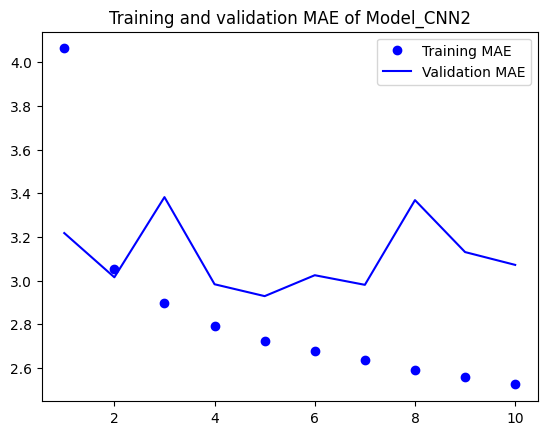

In [ ]:
loss = history_cnn2.history["mae"]
val_loss = history_cnn2.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE of Model_CNN2")
plt.legend()
plt.show()

### A first recurrent baseline

**A simple LSTM-based model**

Using Long Short-Term Memory (LSTM) networks for temperature forecasting is a common approach due to their ability to capture long-term dependencies in sequential data.

ong Short-Term Memory (LSTM) networks are a type of recurrent neural network (RNN) designed to capture long-term dependencies in sequential data. The LSTM layer consists of memory cells and various gates that control the flow of information through the cell over time.

In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(16)(inputs)
outputs = layers.Dense(1)(x)
model_lstm = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm.keras",
                                    save_best_only=True)
]
model_lstm.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history_lstm = model_lstm.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model_lstm = keras.models.load_model("jena_lstm.keras")
print(f"Test MAE: {model_lstm.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 45s 52ms/step - loss: 40.8880 - mae: 4.6563 - val_loss: 14.8472 - val_mae: 2.7988
Epoch 2/10
819/819 [==============================] - 52s 63ms/step - loss: 10.8474 - mae: 2.5552 - val_loss: 9.6142 - val_mae: 2.4110
Epoch 3/10
819/819 [==============================] - 43s 52ms/step - loss: 9.4726 - mae: 2.4035 - val_loss: 9.3955 - val_mae: 2.3797
Epoch 4/10
819/819 [==============================] - 51s 62ms/step - loss: 8.9685 - mae: 2.3429 - val_loss: 9.5166 - val_mae: 2.3818
Epoch 5/10
819/819 [==============================] - 50s 61ms/step - loss: 8.6708 - mae: 2.3051 - val_loss: 9.6470 - val_mae: 2.3877
Epoch 6/10
819/819 [==============================] - 42s 52ms/step - loss: 8.4490 - mae: 2.2764 - val_loss: 9.7563 - val_mae: 2.4017
Epoch 7/10
819/819 [==============================] - 43s 53ms/step - loss: 8.2683 - mae: 2.2524 - val_loss: 10.2608 - val_mae: 2.4442
Epoch 8/10
819/819 [==============================] - 53s 

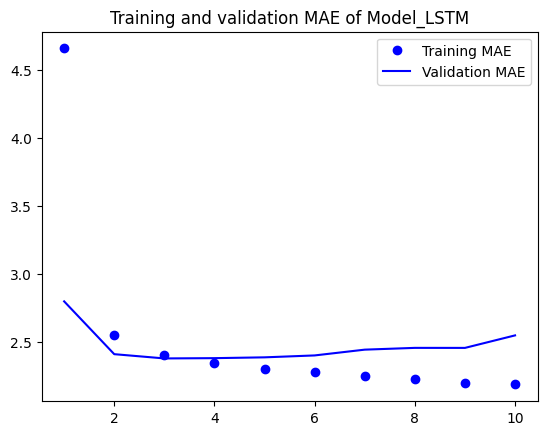

In [ ]:
loss = history_lstm.history["mae"]
val_loss = history_lstm.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE of Model_LSTM")
plt.legend()
plt.show()

## Advanced use of recurrent neural networks

### Using recurrent dropout to fight overfitting

**Training and evaluating a dropout-regularized LSTM**

In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(32, recurrent_dropout=0.25)(inputs)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model_lstm2 = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm_dropout.keras",
                                    save_best_only=True)
]
model_lstm2.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history_lstm2 = model_lstm2.fit(train_dataset,
                    epochs=5,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model_lstm2 = keras.models.load_model("jena_lstm_dropout.keras")
print(f"Test MAE: {model_lstm2.evaluate(test_dataset)[1]:.2f}")

NameError: name 'keras' is not defined

In [ ]:
loss = history_lstm2.history["mae"]
val_loss = history_lstm2.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE of Model_LSTM2")
plt.legend()
plt.show()

### Stacking recurrent layers

**Training and evaluating a dropout-regularized, stacked GRU model**

A Gated Recurrent Unit (GRU) layer is another type of recurrent neural network (RNN) layer that is similar to LSTM (Long Short-Term Memory) but with some variations in its architecture. GRU was introduced as a simpler alternative to LSTM, with fewer parameters and computational complexity, yet still capable of capturing long-term dependencies in sequential data.

In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.GRU(32, recurrent_dropout=0.5, return_sequences=True)(inputs)
x = layers.GRU(32, recurrent_dropout=0.5)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model_gru = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_stacked_gru_dropout.keras",
                                    save_best_only=True)
]
model_gru.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history_gru = model_gru.fit(train_dataset,
                    epochs=5,
                    validation_data=val_dataset,
                    callbacks=callbacks)
model_gru = keras.models.load_model("jena_stacked_gru_dropout.keras")
print(f"Test MAE: {model_gru.evaluate(test_dataset)[1]:.2f}")

Epoch 1/5
819/819 [==============================] - 551s 666ms/step - loss: 25.7634 - mae: 3.7399 - val_loss: 9.6591 - val_mae: 2.4182
Epoch 2/5
819/819 [==============================] - 550s 671ms/step - loss: 14.0301 - mae: 2.9013 - val_loss: 9.2592 - val_mae: 2.3681
Epoch 3/5
819/819 [==============================] - 555s 677ms/step - loss: 13.3444 - mae: 2.8332 - val_loss: 9.1182 - val_mae: 2.3465
Epoch 4/5
819/819 [==============================] - 541s 660ms/step - loss: 12.7838 - mae: 2.7730 - val_loss: 9.0213 - val_mae: 2.3284
Epoch 5/5
819/819 [==============================] - 544s 663ms/step - loss: 12.3069 - mae: 2.7236 - val_loss: 8.6501 - val_mae: 2.2817


405/405 [==============================] - 43s 105ms/step - loss: 9.7202 - mae: 2.4505
Test MAE: 2.45


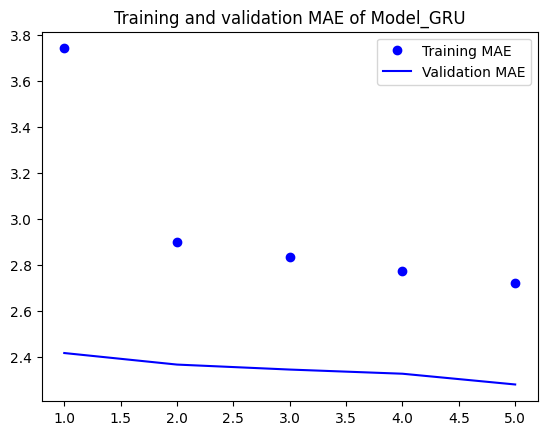

In [ ]:
loss = history_gru.history["mae"]
val_loss = history_gru.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE of Model_GRU")
plt.legend()
plt.show()

Compare the test MAE results of the 5 models above. Are you able to modify any of the networks to improve this performance?

## References

Chollet, F. (2017). Deep learning with python. Manning Publications.